In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import scipy.optimize as sco 
from datetime import timedelta

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

data = pd.read_excel('datos_fwd_vs_opcion.xlsx')
data.set_index('Date',inplace=True)
data.sort_values(by='Date',inplace=True)
print('Dia primero: {} \n Dia ultimo: {}'.format(data.index.min(),data.index.max()))

Dia primero: 2015-01-05 00:00:00 
 Dia ultimo: 2020-07-03 00:00:00


In [2]:
#Análisis a tres meses
inputs = data[['USDPEN','Outright 3M','ATM VOL MID, 3M', 'Tasa Efectiva 3M','Tasa Implicita 3M']].dropna()

##### Las variables involucradas en la metodología son:

$S_{0}$: Spot    
$K$: Strike    
$T$: Tiempo de duracion    
$rCCY1$: Tasa pasiva extranjera   
$rCCY2$: Tasa activa local  


##### Black-Scholes Formula para FX:
$$
Price_{call} = S_{0}e^{-rCCY1.T}N(d_{1}) - Ke^{-rCCY2.T}N(d_{2})
$$


###### Donde:

$$
d_{1} = \dfrac{\ln({\dfrac{S}{K}}) + (rCCY2-rCCY1 + 0.5\sigma^{2}).T}{\sigma \surd T}
$$

$$
d_{2} = \dfrac{\ln({\dfrac{S}{K}}) + (rCCY2-rCCY1 - 0.5\sigma^{2}).T}{\sigma \surd T}
$$


In [3]:
def d1_f(S0, K, t, rd, rf, vol):
  """
  d1
  """
  return (np.log(S0/K) + (rd - rf + (0.5 * vol**2))*t / (vol*np.sqrt(t)))

def d2_f(S0, K, t, rd, rf, vol):
  """
  d2
  """
  return (np.log(S0/K) + (rd - rf - (0.5*vol**2))*t / (vol*np.sqrt(t)))

def d2_2(S0,K,t,rd,rf,vol):
    return d1(S0,K,t,rf,rf,vol) - vol*sqrt(t)
 
def value_call_or_put(S0,K,t,rd,rf,vol,type='call'):
  #Estos tendrán que ser Estados en la clase? 
    d1 = d1_f(S0,K,t,rd,rf,vol)
    d2 = d2_f(S0,K,t,rd,rf,vol)
    if type == 'call':
        value_call = (S0 * norm.cdf(d1, 0.0, 1.0) - K*np.exp(-rf * t) * norm.cdf(d2, 0.0, 1.0))
        return value_call/100
    elif type == 'put':
        value_put = (-S0 * norm.cdf(-d1, 0.0, 1.0) + K*np.exp(-rf * t) * norm.cdf(-d2,0.0,1.0))
        return value_put/100
    else:
        raise ValueError

def value_vanilla_forward(S0,t,rd,rf):
    return S0*(1+rf*t/360)/(1+rd*t/360)

##### Para poder comparar los dos instrumentos se toma en cuenta que:

El que compra la opción call o el forward puede ganar o perder dependiendo de la diferencia entre el $Spot_{T}$ y el $Strike(K)$ en la fecha de maduración **(T)** del contrato. 

Para poder comparar estas ganancias o pérdidas, entendiendo que el contrado es de compra USD/PEN, se usa:

(1 - (TC Final de compra)/(TC que se deja de lado))


Por ejemplo, si hay un fwd a 3M, con un $TC_{fwd}$ de 3.5 y el spot después de 3M es de


Si es que el Strike es mayor que el $Spot_{T}$:

$$  (1 - \frac{Spot_{T}}{Strike}) - Prima $$

Si es que el $Spot_{T}$ es menor que el Strike y no se ejecuta la opción

$$ (1 - \frac{Strike}{Spot_{T}}) - Prima$$

Sin cobertura, se asume que la empresa está asumiendo un costo el tipo de cambio spot a tres meses y no comprarlos en el día del contrato (hoy). 

$$ (1- \frac{Spot_{T}}{Spot_{0}})$$

In [4]:
def estrategia_fwd(tc_fwd, spot_final, type='call'):
  #Los puntos que yo pago por entrar a un fwd?
  return (1- (tc_fwd/spot_final))

def prima_total(prima_opcion, strike, spot_final, type='compra'):
  #Los puntos que yo pierdo/gano por tener la opción al ATM 3M.
  #Se asume, también, que gano si es que prefiero irme al spot
    if float(strike) > float(spot_final):
        return - prima_opcion + (1-(spot_final/strike))
    else:
        return (1 - (strike/spot_final)) - prima_opcion

def sin_cobertura(spot_final, spot_inicial, type='compra'):
      return (1 - (spot_final/spot_inicial))

### Transformación de datos:

In [5]:
inputs[(inputs.index >= '2017-01-01') & (inputs.index <= '2019-01-01')].index.max()

Timestamp('2018-12-31 00:00:00')

In [109]:
#inputs = data[['USDPEN','Outright 3M','TEA_3M','Implied_3M','ATM VOL MID 3M']]
#S - K - Rd - Rf - vol 

#Establezco los días para hacer el análisis a 3M
start_date_requerido = '2015-01-01'
final_date_requerido = '2017-01-01'

start_date = inputs[(inputs.index >= start_date_requerido) & (inputs.index < final_date_requerido)].index.min()
final_date = inputs[(inputs.index >= start_date_requerido) & (inputs.index < final_date_requerido)].index.max()

In [110]:
rango_dias_totales = pd.date_range(start_date, final_date - timedelta(days=1), freq='d')
cota_superior_test = start_date + timedelta(days=88)
cota_inferior_input = final_date - timedelta(days=90)
print(rango_dias_totales)
#Tengo la lista de todos los días de la semana. Para que no haya errores en cuanto a los fds y feriados
df = pd.DataFrame(rango_dias_totales).rename(columns={0:'Date'}).merge(inputs.reset_index(), on='Date', how='outer').bfill()
#Borraré los fines de semana.
test_df = df[(df['Date']>= cota_superior_test)]
input_df = df[(df['Date']>= start_date)&(df['Date']<= cota_inferior_input)]

DatetimeIndex(['2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27',
               '2016-12-28', '2016-12-29'],
              dtype='datetime64[ns]', length=724, freq='D')


In [111]:
input_df.sort_values('Date')

,Date,USDPEN,Outright 3M,"ATM VOL MID, 3M",Tasa Efectiva 3M,Tasa Implicita 3M
0,2015-01-06,2.9895,3.0460,6.4225,0.143095,0.231991
1,2015-01-07,2.9905,3.0537,6.4250,0.140885,0.240430
2,2015-01-08,2.9825,3.0595,6.5000,0.132080,0.253594
3,2015-01-09,2.9875,3.0580,6.7675,0.137577,0.248818
4,2015-01-10,2.9815,3.0580,6.8950,0.135376,0.256465
...,...,...,...,...,...,...
630,2016-09-27,3.3655,3.4415,8.7850,0.723294,0.884309
631,2016-09-28,3.3730,3.4265,8.4850,0.741414,0.854555
632,2016-09-29,3.3960,3.4355,8.6925,0.747486,0.830218
633,2016-09-30,3.3835,3.4360,8.5175,0.747486,0.858496


In [112]:
print('test shape: {}\ninput shape: {}'.format(test_df.shape, input_df.shape))
#Creo mis variables.
#df.set_index('Date',inplace=True)
final_df = input_df.copy()
columnas_finales = [*input_df.columns] + ['Spot_final','Prima_opcion','Estrategia fwd','Estrategia opción']
final_df = final_df.reindex(columns=columnas_finales)
final_df.set_index('Date', inplace=True)
#df.set_index('Date',inplace=True)
final_df['Prima_opcion'] = final_df.apply(lambda x: value_call_or_put(x['USDPEN'], x['Outright 3M'], 90, x['Tasa Efectiva 3M'], x['Tasa Implicita 3M'],x['ATM VOL MID, 3M']),axis=1)
for fecha in final_df.index:
    try:
        #print('fecha: {} Eval: {}'.format(fecha, fecha+timedelta(days=90)))
        final_df['Spot_final'][fecha] = df.set_index('Date')['USDPEN'][fecha + timedelta(days=90)]
    except KeyError:
        print(fecha, 'y',fecha+timedelta(days=90))
final_df['Estrategia fwd'] = final_df.apply(lambda x: estrategia_fwd(x['Outright 3M'], x['Spot_final']),axis=1)
final_df['Estrategia opción'] = final_df.apply(lambda x: prima_total(x['Prima_opcion'], x['Outright 3M'], x['Spot_final'],x['USDPEN']),axis=1)
final_df['Sin_cobertura'] = final_df.apply(lambda x: sin_cobertura(x['Spot_final'],x['USDPEN']),axis=1)

#Borrare los Fines de Semana. Pero, aún falta sacarle los feriados.
final_df = final_df[final_df.index.dayofweek < 5]
final_df['Cero'] = 0.0

test shape: (1512, 6)
input shape: (635, 6)


### Gráfico a 3 Meses

2015-01-06 00:00:00
2016-09-30 00:00:00


Text(0, 0.5, 'daily returns')

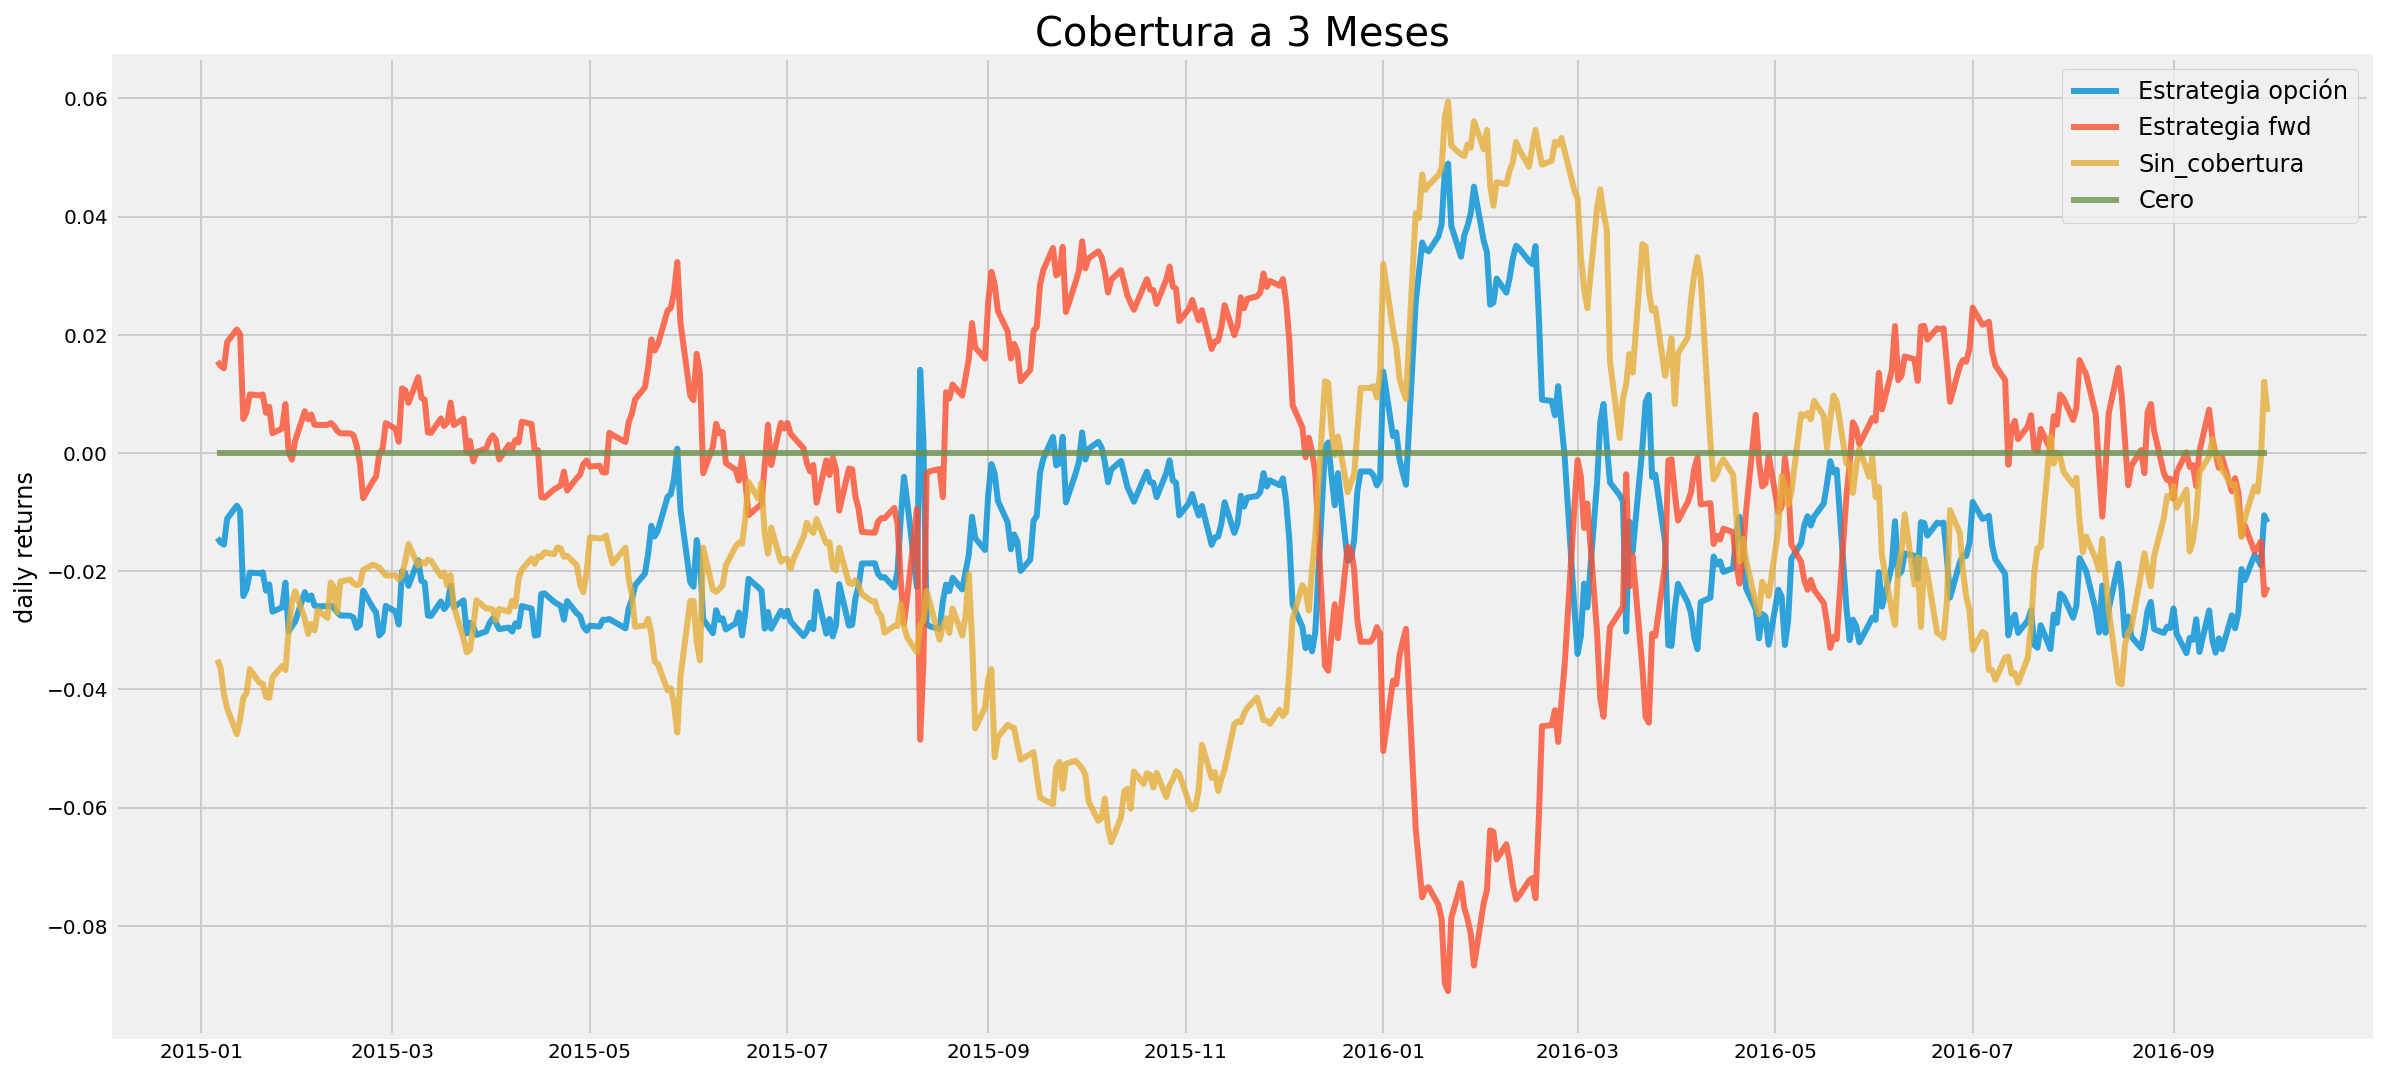

In [170]:
plt.figure(figsize=(18,9))
for c in final_df[['Estrategia opción','Estrategia fwd','Sin_cobertura','Cero']]:
    plt.plot(final_df.index, final_df[c], lw=3, alpha=0.8, label=c)
print(final_df.index.min())
print(final_df.index.max())
plt.title('Cobertura a 3 Meses',fontsize=20)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [108]:
final_df.tail(15)

,USDPEN,Outright 3M,"ATM VOL MID, 3M",Tasa Efectiva 3M,Tasa Implicita 3M,Spot_final,Prima_opcion,Estrategia fwd,Estrategia opción,Sin_cobertura,Cero
Date,,,,,,,,,,,
2018-09-12,3.3300,3.3345,4.0550,4.930005,4.962125,3.3610,0.033300,0.007885,-0.025415,-0.009309,0.0
2018-09-13,3.3148,3.3270,4.0500,4.931906,5.019718,3.3585,0.033148,0.009379,-0.023769,-0.013183,0.0
2018-09-14,3.3100,3.3242,4.0400,4.928106,5.030489,3.3520,0.033100,0.008294,-0.024806,-0.012689,0.0
2018-09-17,3.3115,3.3176,4.0625,4.937609,4.981480,3.3395,0.033115,0.006558,-0.026557,-0.008455,0.0
2018-09-18,3.3047,3.3127,4.0875,4.964280,5.022243,3.3395,0.033047,0.008025,-0.025022,-0.010530,0.0
2018-09-19,3.3035,3.3095,3.9300,4.968098,5.011574,3.3479,0.033035,0.011470,-0.021565,-0.013440,0.0
2018-09-20,3.2970,3.3190,3.9200,4.968098,5.128993,3.3520,0.032970,0.009845,-0.023125,-0.016682,0.0
2018-09-21,3.2935,3.3230,3.9000,5.014050,5.232435,3.3495,0.032935,0.007912,-0.025023,-0.017003,0.0
2018-09-24,3.2980,3.3205,3.9500,5.050617,5.217431,3.3600,0.032980,0.011756,-0.021224,-0.018799,0.0


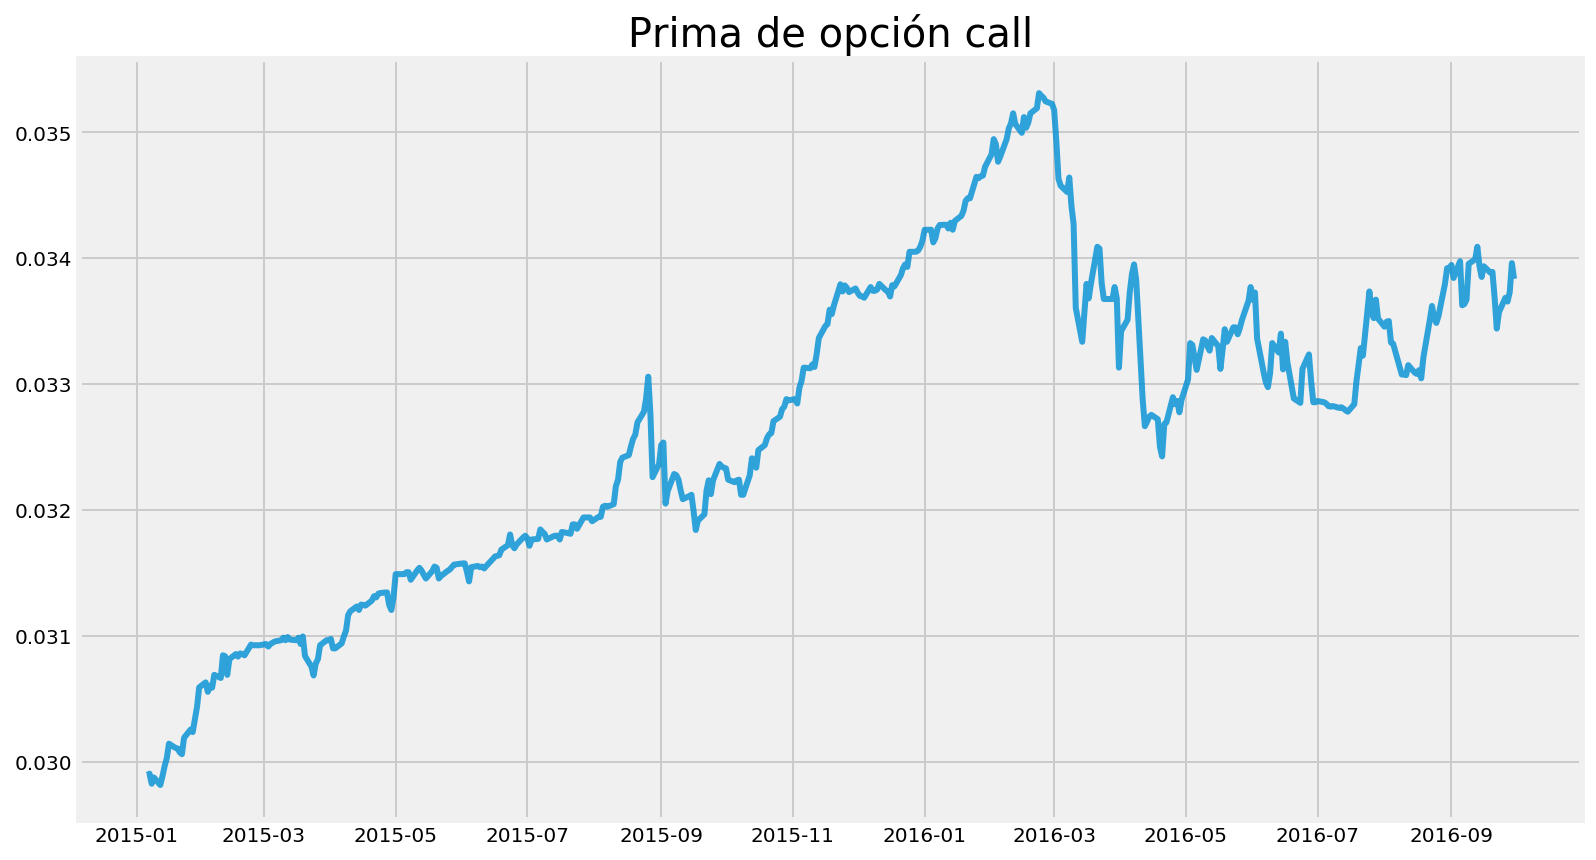

In [169]:
plt.figure(figsize=(12,7))
plt.title('Prima de opción call',fontsize=20)
plt.plot(final_df.index, final_df['Prima_opcion'],lw=3, alpha=0.8)

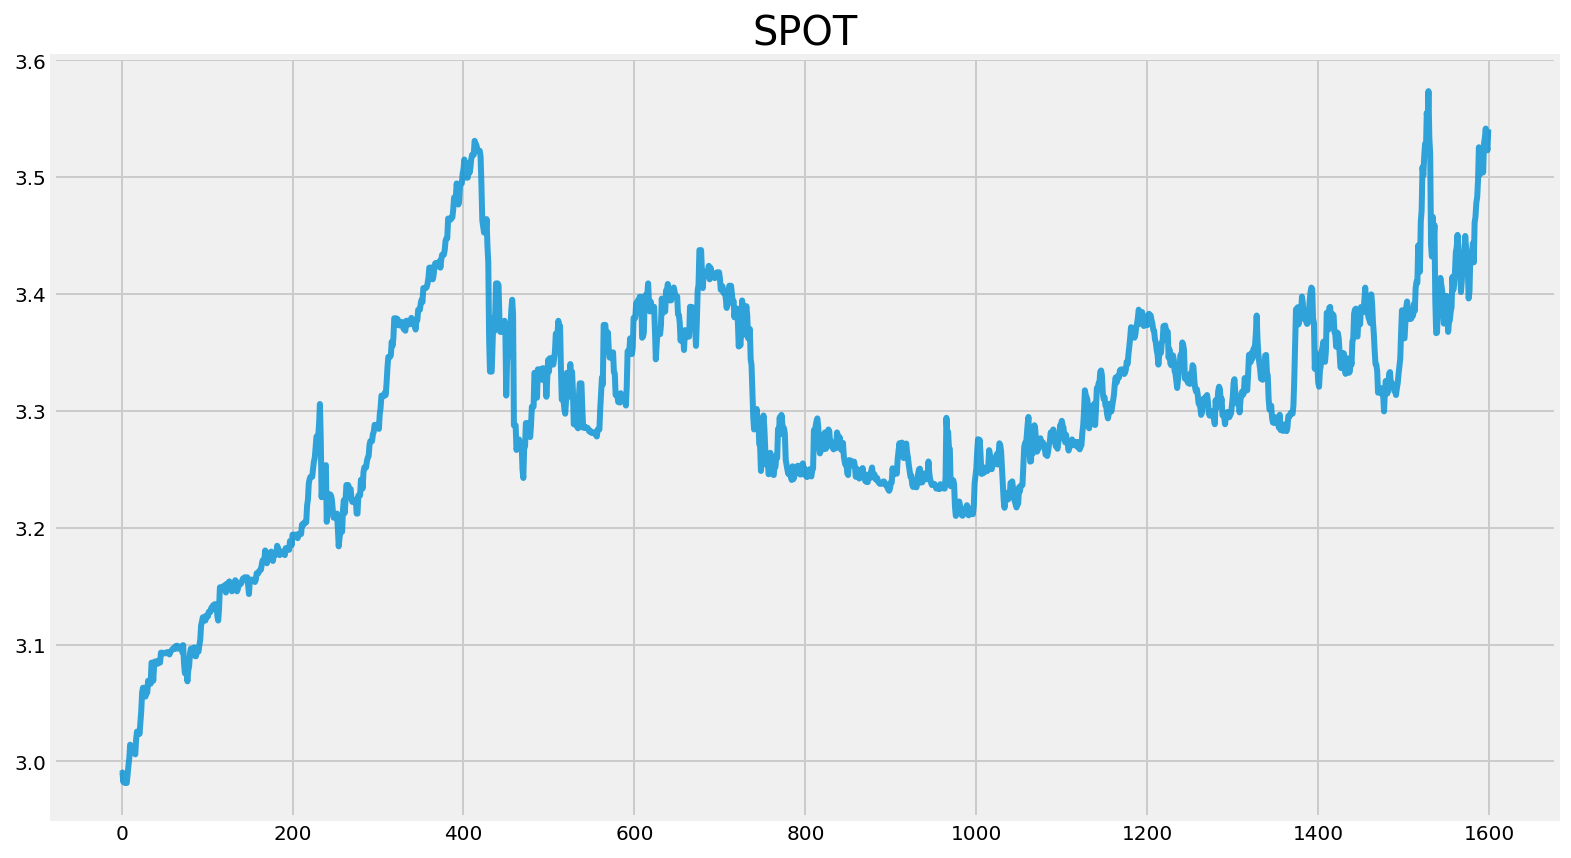

In [168]:
#Spot
plt.figure(figsize=(12,7))
plt.title('SPOT',fontsize=20)
plt.plot(df.index, df['USDPEN'],lw=3, alpha=0.8)

In [117]:
final_df

,USDPEN,Outright 3M,"ATM VOL MID, 3M",Tasa Efectiva 3M,Tasa Implicita 3M,Spot_final,Prima_opcion,Estrategia fwd,Estrategia opción,Sin_cobertura,Cero
Date,,,,,,,,,,,
2015-01-06,2.9895,3.0460,6.4225,0.143095,0.231991,3.0940,0.029895,0.015514,-0.014381,-0.034956,0.0
2015-01-07,2.9905,3.0537,6.4250,0.140885,0.240430,3.0995,0.029905,0.014777,-0.015128,-0.036449,0.0
2015-01-08,2.9825,3.0595,6.5000,0.132080,0.253594,3.1040,0.029825,0.014336,-0.015489,-0.040738,0.0
2015-01-09,2.9875,3.0580,6.7675,0.137577,0.248818,3.1165,0.029875,0.018771,-0.011104,-0.043180,0.0
2015-01-12,2.9815,3.0580,6.8950,0.135376,0.256465,3.1233,0.029815,0.020907,-0.008908,-0.047560,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,3.3685,3.4440,8.8825,0.711293,0.869953,3.3875,0.033685,-0.016679,-0.017280,-0.005640,0.0
2016-09-27,3.3655,3.4415,8.7850,0.723294,0.884309,3.3875,0.033655,-0.015941,-0.017964,-0.006537,0.0
2016-09-28,3.3730,3.4265,8.4850,0.741414,0.854555,3.3760,0.033730,-0.014959,-0.018992,-0.000889,0.0


### Optimización 

In [143]:
from math import copysign
def performance_anualizado_portafolio(weights, media_retornos, cov_matrix):
    """
    Me dará los retornos totales de mi portafolio, junto a la desv_standar del mismo
    """
    retornos_totales = np.sum(media_retornos*weights) * 454 #La media de retornos al día, por 454 días.
    desv_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(454) #Tengo la dsv stand del portafolio
    return desv_std, retornos_totales

def neg_sharpe_ratio(weights,media_retornos, cov_matrix, risk_free_rate):
    sign = 0
    desv_standar_portafolio, retornos_portafolio = performance_anualizado_portafolio(weights, media_retornos, cov_matrix) #Obtengo la desv y retornos totales
    ratio_sharpe = (retornos_portafolio - risk_free_rate)/desv_standar_portafolio
    #Si los retornos son negativos, voy a quitarle el menos pq está implícito. En vaso contrario, el max. Sharpe caería fuera de la Frontera Efic.
    if copysign(1, ratio_sharpe) == -1:
        sign = 0 
    else:
        sign = 1
    return (ratio_sharpe)*(-1)**sign

def max_sharpe(media_retornos, cov_matrix, risk_free_rate):
    """
    Función de maximización para el ratio de Sharpe
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix, risk_free_rate)
    restricciones = ({'type':'eq','fun':lambda x: np.sum(x)-1}) #Esta es la restricción para que los pesos sumen 1
    limite = (0.0,1.0) #Los limites de los valores de los pesos.
    limites = tuple(limite for accion in range(num_acciones)) #creo N limites
    result = sco.minimize(neg_sharpe_ratio, initial_weights, args=args,
                         method='SLSQP',bounds=limites, constraints=restricciones)
    return result

def volatilidad_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[0]

def retorno_portafolio(weights, media_retornos, cov_matrix):
    return performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def neg_retorno_portafolio(weights, media_retornos, cov_matrix):
    return -performance_anualizado_portafolio(weights, media_retornos, cov_matrix)[1]

def varianza_minima(media_retornos, cov_matrix):
    """
    Función de minimización de varianza del portafolio.
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_min_varianza = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds=limites,constraints = restricciones)
    return result_min_varianza

def max_rentabilidad(media_retornos, cov_matrix):
    """
    Función de maximización del retorno
    """
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    restricciones = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    limite = (0.0, 1.0)
    limites = tuple(limite for asset in range(num_acciones))
    
    result_max_retorno = sco.minimize(neg_retorno_portafolio, num_acciones*[1./num_acciones,], args=args,
                                     method='SLSQP',bounds = limites,constraints=restricciones)
    return result_max_retorno

def retornos_eficientes(media_retornos, cov_matrix, target):
    num_acciones = len(media_retornos)
    args = (media_retornos, cov_matrix)
    
    #Acá la restricción es el retorno del portafolio, pero con 
    restricciones = ({'type':'eq','fun': lambda x: retorno_portafolio(x, media_retornos, cov_matrix) - target},
                    {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    
    limites = tuple((0,1) for accion in range(num_acciones))
    
    retornos_eficientes = sco.minimize(volatilidad_portafolio, num_acciones*[1./num_acciones,], args = args, method='SLSQP', bounds = limites, constraints=restricciones)
    
    return retornos_eficientes

def frontera_eficiente(media_retornos, cov_matrix, rango_retornos):
    """
    Esta función me va a calcular varios portafolios eficientes en un dentro de un rango retornos requerido.
    Recuerda que el rango de retornos máximo, será el portafolio que me de más rentabilidad. Por lo tanto, tendré también que optimizar c/r a la rentabilidad.
    """
    eficientes = []
    for retorno in rango_retornos:
        eficientes.append(retornos_eficientes(media_retornos, cov_matrix, retorno))
    return eficientes

def frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data):
    
    #----------------------------Optimizaciones-------------------------
    sharpe_maximo = max_sharpe(media_retornos, cov_matrix, risk_free_rate)
    sharpe_dsv, sharpe_retornos = performance_anualizado_portafolio(weights=sharpe_maximo['x'], #Los weights serán los valores que me botan la maximización
                                                                    media_retornos = media_retornos, cov_matrix = cov_matrix)
    sharpe_max_posicion = pd.DataFrame(sharpe_maximo['x'], index = data.columns, columns=['Posicion'])
    sharpe_max_posicion['Posicion'] = [round(i*100,2) for i in sharpe_max_posicion['Posicion']]
    sharpe_max_posicion = sharpe_max_posicion.T
    print(sharpe_dsv,'dsv',sharpe_retornos,'returns')
    print('Optimizando Ratio de Sharpe:')
    print(sharpe_max_posicion)
    
    volat_min = varianza_minima(media_retornos, cov_matrix)
    dsv_min_var, dsv_min_retornos = performance_anualizado_portafolio(weights=volat_min['x'], media_retornos=media_retornos, cov_matrix=cov_matrix)
    volat_min_posicion = pd.DataFrame(volat_min['x'], index=data.columns, columns=['Posicion'])
    volat_min_posicion['Posicion'] = [round(i*100,2) for i in volat_min_posicion['Posicion']]
    volat_min_posicion = volat_min_posicion.T
    print('-------------------------------------------------------------------------------------')
    print('Minimizando Varianza, según nuestro portafolio')
    print(volat_min_posicion)
    max_retorno = max_rentabilidad(media_retornos, cov_matrix)
    dsv_max_retorno, total_retorno_max = performance_anualizado_portafolio(weights=max_retorno['x'], media_retornos = media_retornos, cov_matrix=cov_matrix)
    max_retorno_posicion = pd.DataFrame(max_retorno['x'], index=data.columns, columns=['Posicion'])
    max_retorno_posicion['Posicion'] = [round(i*100,2) for i in max_retorno_posicion['Posicion']]
    max_retorno_posicion = max_retorno_posicion.T
    print('------------------------------------------------------------------------------------')
    print('MAx rentabilidad')
    print(max_retorno_posicion)
    cambio_pct_stocks = data
    retornos_medios_stocks = cambio_pct_stocks.mean()
    volatilidad_anual_stocks = np.std(cambio_pct_stocks) * np.sqrt(454)
    retornos_anual = media_retornos * 454
    
    #Ahora hacemos la figura
    fig, ax = plt.subplots(figsize=(14,8))
    ax.scatter(volatilidad_anual_stocks, retornos_anual, marker='o',s=200)
    
    #Pongo los nombres a cada uno de los puntos.
    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (volatilidad_anual_stocks[i], retornos_anual[i]), xytext=(10,0), textcoords='offset points')
    
    #Gráficos de max_sharpe y varianza minima
    ax.scatter(sharpe_dsv, sharpe_retornos, marker='*', color='r',s=500, label='Maximo Ratios de Sharpe')
    ax.scatter(dsv_min_var, dsv_min_retornos, marker='*', color='g',s=500, label='Minima Volatilidad')
    #ax.scatter(df_sp.pct_change().std()*np.sqrt(454), df_sp.pct_change().mean()*454, marker ='*',color='c',s=500,label='S&P 500 index')
    print(total_retorno_max)
    #Ajustamos la máxima volatilidad de algún stock para el gráfico.
    target = np.linspace(dsv_min_retornos, total_retorno_max, 50) #Esta linea me va a generar un array de 50 muestras con límite de portafolio de máxima rentabilidad.
    
    portafolios_eficientes = frontera_eficiente(media_retornos, cov_matrix, target)
    
    #Grafico todos los portafolios eficientes.
    ax.plot([p['fun'] for p in portafolios_eficientes], target, linestyle='-.', color='black', label='frontera eficiente')
    
    ax.set_title('Optimización del Portafolio de derivados')
    ax.set_xlabel('Volatilidad Anualizada')
    ax.set_ylabel('Retornos Anualizados')
    ax.legend(labelspacing=0.8)

In [144]:
returns = final_df[['Estrategia fwd','Estrategia opción','Sin_cobertura']]
cov_matrix = returns.cov()
media_retornos = returns.mean()

In [145]:
media_retornos

Estrategia fwd      -0.003158
Estrategia opción   -0.015368
Sin_cobertura       -0.015207
dtype: float64

0.1050210425890962 dsv -4.641421465690071 returns
Optimizando Ratio de Sharpe:
          Estrategia fwd  Estrategia opción  Sin_cobertura
Posicion           41.73              27.68          30.59
-------------------------------------------------------------------------------------
Minimizando Varianza, según nuestro portafolio
          Estrategia fwd  Estrategia opción  Sin_cobertura
Posicion            44.0              24.29          31.71
------------------------------------------------------------------------------------
MAx rentabilidad
          Estrategia fwd  Estrategia opción  Sin_cobertura
Posicion           100.0                0.0            0.0
-1.4337111667056583


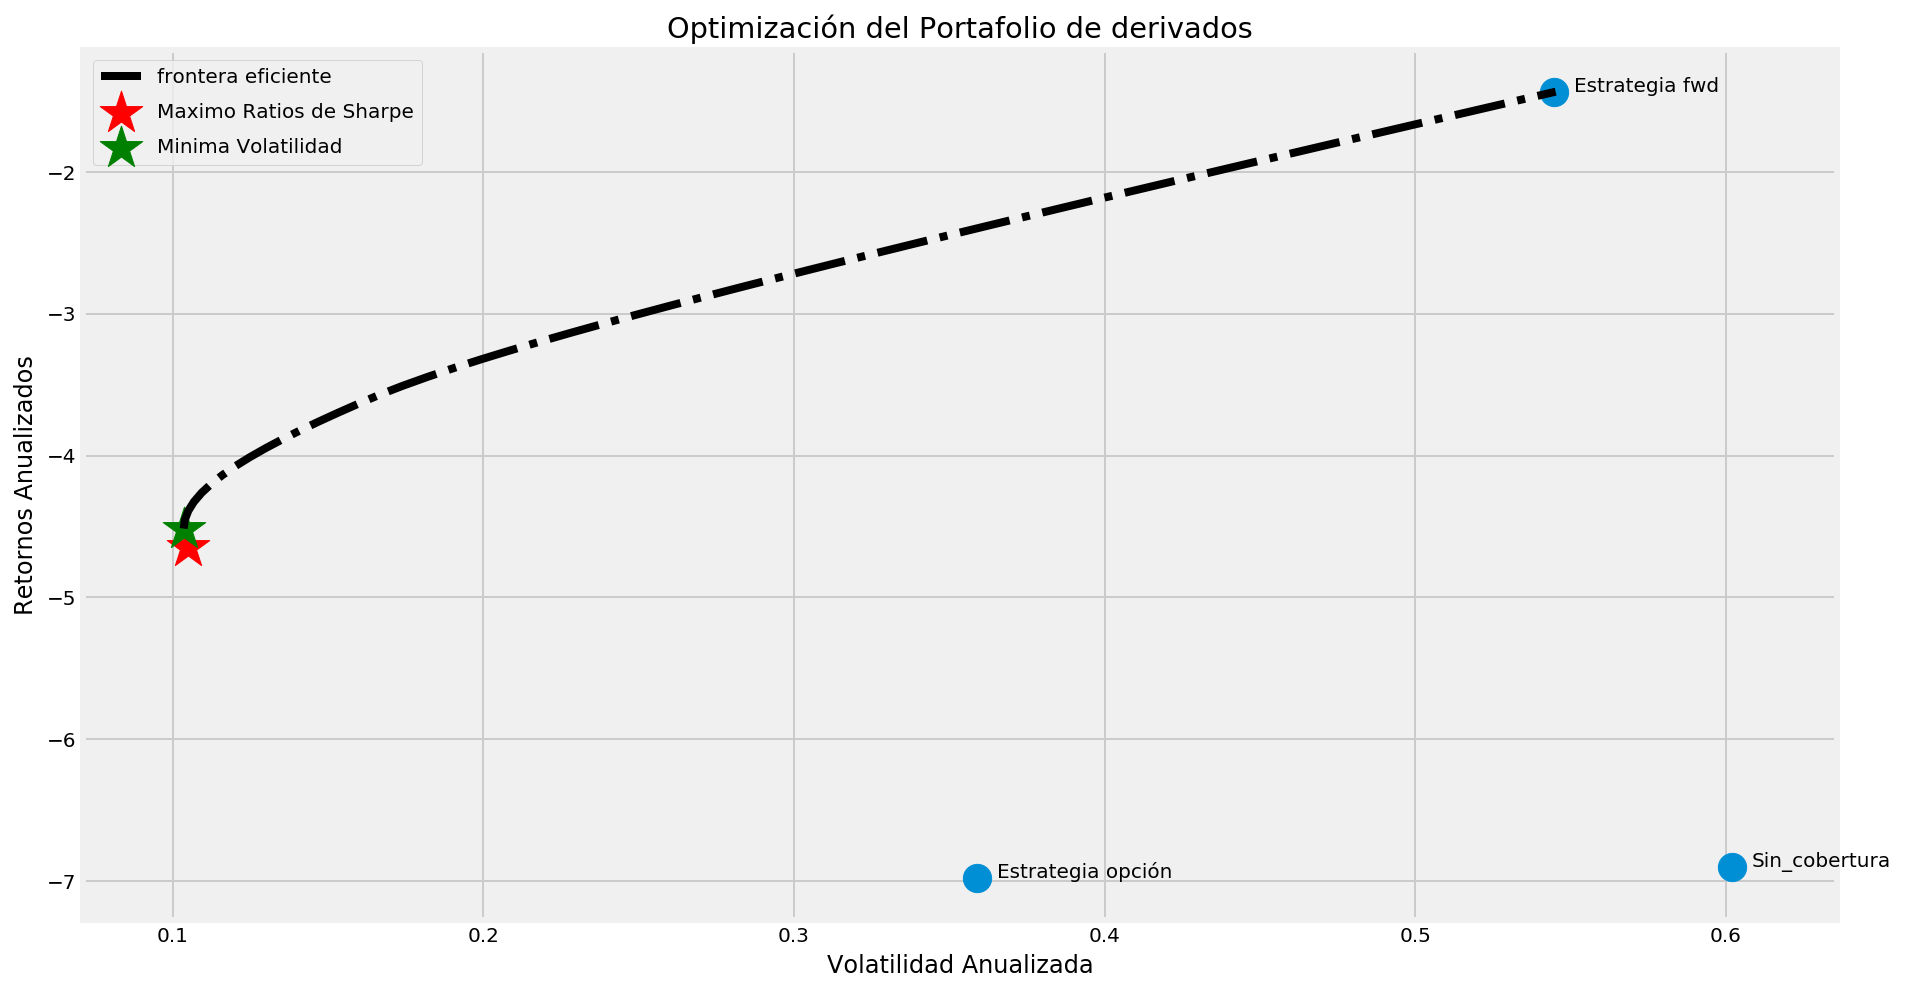

In [146]:
risk_free_rate=0.0035
num_columns = len(returns.columns)
#Estos weights deben estar en porcentajes
initial_weights = np.full(shape=num_columns, fill_value = (1/num_columns))
frontera_eficiente_sharpe_var(media_retornos, cov_matrix, risk_free_rate,data=returns)

### Testeando las estrategias:

In [153]:
#Los órdenes son: fwd, opción y sin cobertura.
weights_min_var = varianza_minima(media_retornos,cov_matrix)['x']
weights_max_sharpe = max_sharpe(media_retornos, cov_matrix, 0.035)['x']

Text(0, 0.5, 'Puntos % ganados')

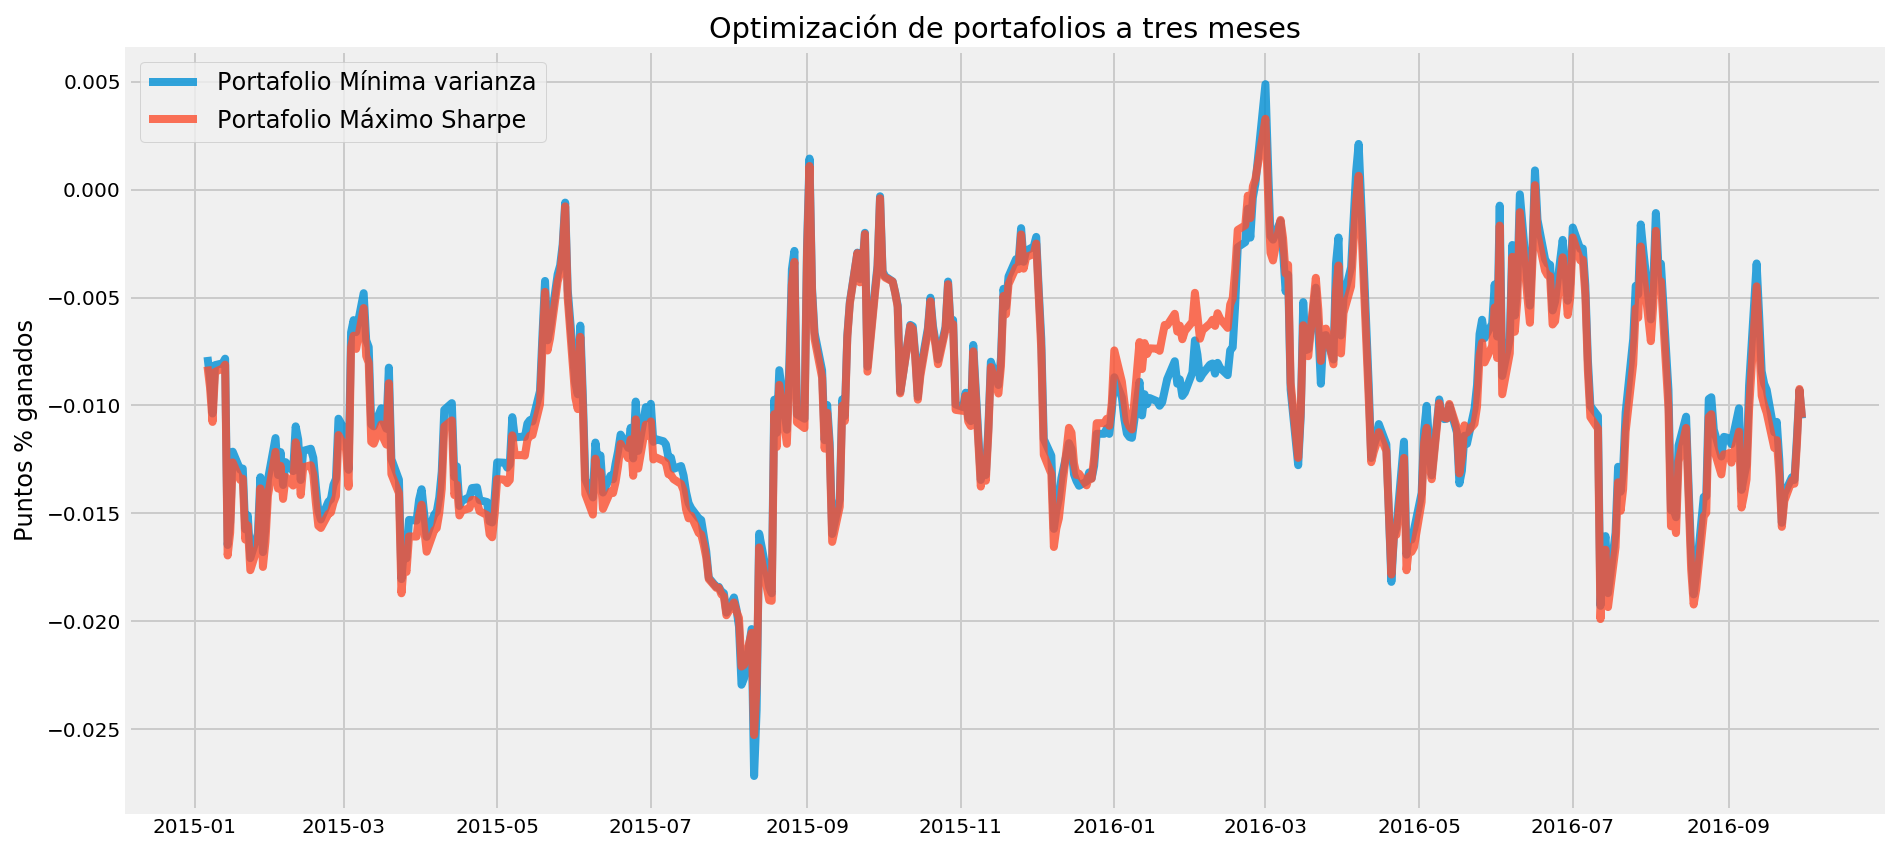

In [167]:
portafolio_final_min_var = np.dot(final_df[['Estrategia fwd','Estrategia opción','Sin_cobertura']],weights_min_var)
portafolio_final_max_sharpe = np.dot(final_df[['Estrategia fwd','Estrategia opción','Sin_cobertura']], weights_max_sharpe)

dataframe_portafolios = pd.DataFrame({'Date':final_df.index,'Portafolio Mínima varianza':portafolio_final_min_var,'Portafolio Máximo Sharpe': portafolio_final_max_sharpe}).set_index('Date')
plt.figure(figsize=(14,7))

for portafolio in dataframe_portafolios.columns.values:
    plt.plot(dataframe_portafolios.index, dataframe_portafolios[portafolio], alpha=0.8, label=portafolio)
    
plt.title('Optimización de portafolios a tres meses')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('Puntos % ganados')

In [156]:
weights_max_sharpe

array([0.41746307, 0.27662359, 0.30591333])